In [1]:
import pandas as pd
import numpy as np
import os
import re

def get_pid(seq1, seq2):
    """
    Calculates the percentage of identical matches between two sequences ignoring gaps.
    Arguments:
      seq1: str - The first sequence.
      seq2: str - The second sequence.
    """
    matches = 0
    for i in range(len(seq1)):
        if seq1[i] == seq2[i] and seq1[i] != '-':
            matches += 1

    min_len = min(len(seq1.replace("-","")), len(seq2.replace("-","")))

    return matches / min_len

def pid_arr(seq1, seq2):

    t  = seq1==seq2
    n1 = seq1!=-1
    n2 = seq2!=-1

    return np.sum(t*n1*n2)/np.minimum(np.sum(n1), np.sum(n2))

def seq2arr(seq):
    """
        Converts a sequence into a numerical representation.
        Arguments:
        seq: str - The sequence.
    """

    a_idx = [m.start() for m in re.finditer('a', seq)]
    c_idx = [m.start() for m in re.finditer('c', seq)]
    g_idx = [m.start() for m in re.finditer('g', seq)]
    t_idx = [m.start() for m in re.finditer('t', seq)]
    n_idx = [m.start() for m in re.finditer('-', seq)]

    seq_arr = np.full(len(seq), np.nan)
    seq_arr[a_idx] = 0
    seq_arr[c_idx] = 1
    seq_arr[g_idx] = 2
    seq_arr[t_idx] = 3
    seq_arr[n_idx] = -1

    return seq_arr

# scientific question
how does genotype information predict a phenotypic trait (antigenic distance)?

In [2]:
reg_path    = os.path.join("data", "dengue", "dengue_phenotype")
seq_path    = os.path.join(reg_path, "sequences")
pheno_path  = os.path.join(reg_path, "antigenicMap")

#### DENV1 sequences ####
denv1_df    = open(os.path.join(seq_path, "d1_n1026.fas"),'r')
denv1_lines = denv1_df.readlines()

denv1_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 1026*2, 2):

    seq      = denv1_lines[i_seq+1][:-1]
    seq_name = denv1_lines[i_seq][1:-1]
    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv1_seq_df = pd.concat([df, denv1_seq_df]).reset_index(drop=True)
denv1_seq_df["virus"] = "DENV1"
############################

#### DENV2 sequences ####
denv2_df    = open(os.path.join(seq_path, "d2_n796.fas"),'r')
denv2_lines = denv2_df.readlines()

denv2_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 796*2, 2):

    seq      = denv2_lines[i_seq+1][:-1]
    seq_name = denv2_lines[i_seq][1:-1]
    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv2_seq_df = pd.concat([df, denv2_seq_df]).reset_index(drop=True)
denv2_seq_df["virus"] = "DENV2"
############################


#### DENV3 sequences ####
denv3_df    = open(os.path.join(seq_path, "d3_n625_degap.fas"),'r')
denv3_lines = denv3_df.readlines()

denv3_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 625*2, 2):

    seq      = denv3_lines[i_seq+1][:-1]
    seq_name = denv3_lines[i_seq][1:-1]

    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv3_seq_df = pd.concat([df, denv3_seq_df]).reset_index(drop=True)
denv3_seq_df["virus"] = "DENV3"
############################


#### DENV3 sequences ####
denv4_df    = open(os.path.join(seq_path, "d4_n477.fas"),'r')
denv4_lines = denv4_df.readlines()

denv4_seq_df = pd.DataFrame(columns=['seq_name', 'seq'])
for i_seq in np.arange(0, 477*2, 2):

    seq      = denv4_lines[i_seq+1][:-1]
    seq_name = denv4_lines[i_seq][1:-1]

    df       = pd.DataFrame(columns=['seq_name', 'seq'], data=[[seq_name, seq]])

    denv4_seq_df = pd.concat([df, denv4_seq_df]).reset_index(drop=True)
denv4_seq_df["virus"] = "DENV4"
############################

denv_seq_df = pd.concat([denv1_seq_df, denv2_seq_df, denv3_seq_df, denv4_seq_df]).reset_index(drop=True)

In [3]:
# check that all sequences have the same length / are already aligned
length_seq = [len(seq) for seq in denv_seq_df["seq"]]
np.sum(np.array(length_seq)==10188)/len(length_seq)

1.0

In [4]:
def pid_arr(seq, sequences_arr):
    seq1 = seq
    seqs = sequences_arr[:, :]

    t  = seq1 == seqs
    n1 = seq1 != -1
    n2 = seqs != -1

    return np.sum(t*n1*n2, axis=1)/np.minimum(np.sum(n1), np.sum(n2, axis=1))


seq_arr    = np.array([seq2arr(seq) for seq in denv_seq_df["seq"]])
pid_arr    = np.array([pid_arr(seq, seq_arr) for seq in seq_arr])
pid_arr_df = pd.DataFrame(data=pid_arr, columns=denv_seq_df["seq_name"], index=denv_seq_df["seq_name"])

Text(95.7222222222222, 0.5, '')

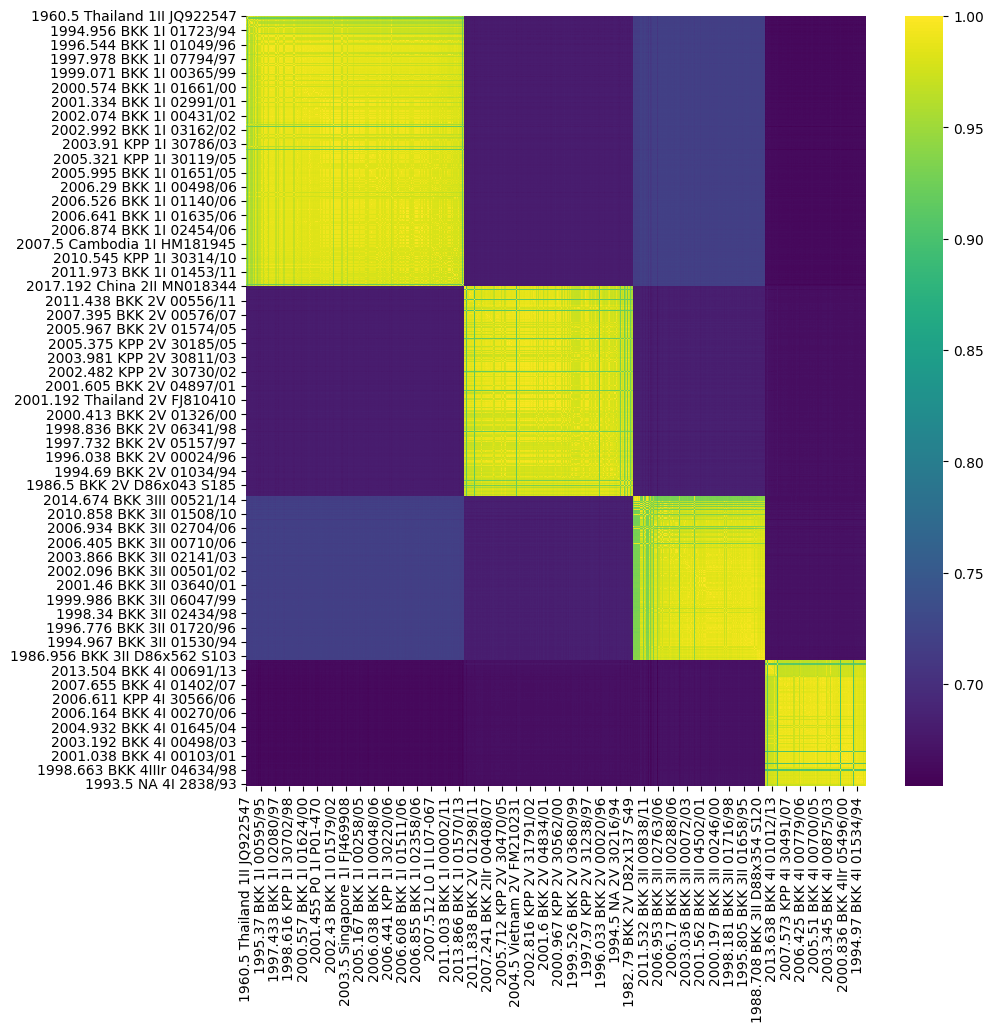

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(pid_arr_df, ax=ax, cmap="viridis")

ax.set_xlabel(None)
ax.set_ylabel(None)

In [6]:
import itertools
def flatten_list(l):
    return list(itertools.chain.from_iterable(l))

pid_df              = pd.melt(pid_arr_df.reset_index(), value_vars=denv_seq_df.seq_name.values)
pid_df['seq2_name'] = flatten_list([list(denv_seq_df.seq_name.values)]*len(denv_seq_df))
pid_df              = pid_df.rename(columns={"value":"pid", "seq_name":"seq1_name"})[["seq1_name", "seq2_name", "pid"]]

pid_df["strain1_id"] = pid_df["seq1_name"].apply(lambda x: x.split(" ")[-1])
pid_df["strain2_id"] = pid_df["seq2_name"].apply(lambda x: x.split(" ")[-1])


## read antigenic phenotype dataframe

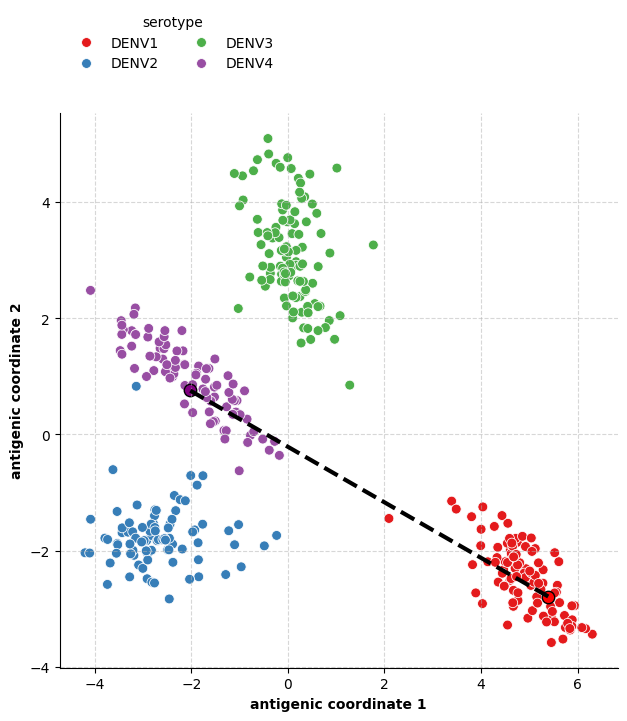

In [7]:
anti_map_2d_df             = pd.read_csv(os.path.join(pheno_path, "ac2D_coords_Thai.csv"))
anti_map_2d_df             = anti_map_2d_df.dropna(subset=["strainID"]) # DROP 3 row THAT ARE NANs
anti_map_2d_df["serotype"] = anti_map_2d_df["sero"].apply(lambda x: "DENV{}".format(x))

strain1 = "00532/94"
strain2 = "00555/14"

strain1_df = anti_map_2d_df[anti_map_2d_df.strainID==strain1]
strain2_df = anti_map_2d_df[anti_map_2d_df.strainID==strain2]

fig, ax = plt.subplots(1, 1, figsize=(7.2, 7.2))
sns.scatterplot(data = anti_map_2d_df,
            x        = "coord1",
            y        = "coord2",
            hue      = "serotype",
            palette  = "Set1",
            s        = 50)

ax.scatter(strain1_df["coord1"], strain1_df["coord2"], color="red", ec="k", s=80)
ax.scatter(strain2_df["coord1"], strain2_df["coord2"], color="purple", ec="k", s=80)

ax.plot([strain1_df["coord1"].values[0], strain2_df["coord1"].values[0]], [strain1_df["coord2"].values[0], strain2_df["coord2"].values[0]],
        color="black", linestyle="--", lw=3)

ax.legend(loc='upper left', bbox_to_anchor=(0., 1.2), title="serotype", ncol=2, frameon=False)
ax.set_xlabel("antigenic coordinate 1", weight="bold")
ax.set_ylabel("antigenic coordinate 2", weight="bold")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.grid(True, linestyle='--', alpha=0.5)


In [8]:


antigenic_mat_arr = np.full((len(anti_map_2d_df), len(anti_map_2d_df)), np.nan)

for i in range(len(anti_map_2d_df)):
    for j in range(i, len(anti_map_2d_df)):
        strain1 = anti_map_2d_df["strainID"].iloc[i]
        strain2 = anti_map_2d_df["strainID"].iloc[j]

        strain1_df = anti_map_2d_df[anti_map_2d_df.strainID.isin([strain1, strain2])]
        if len(strain1_df) == 1:
            anti_dis = 0
        else:
            anti_dis = np.sqrt((strain1_df["coord1"].values[0]-strain1_df["coord1"].values[1])**2 +
                               (strain1_df["coord2"].values[0]-strain1_df["coord2"].values[1])**2)
        antigenic_mat_arr[i, j] = anti_dis
        #antigenic_mat_arr[j, i] = anti_dis

Text(64.47222222222221, 0.5, '')

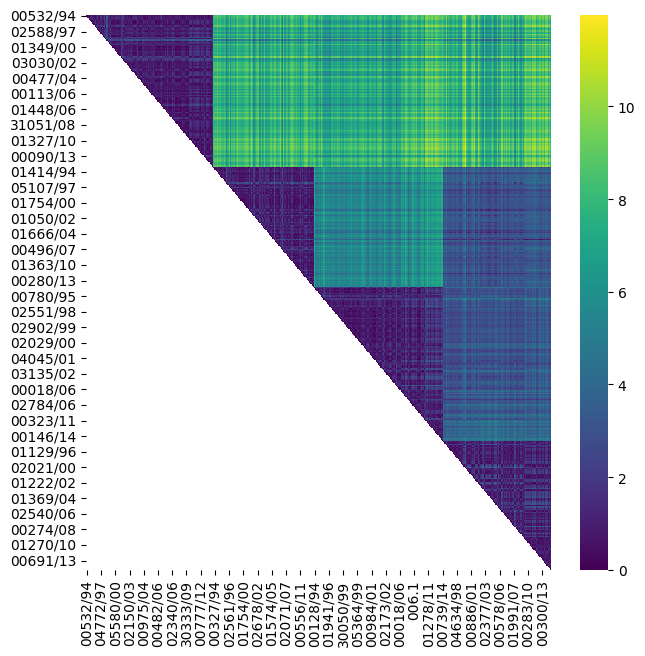

In [9]:
ant_mat_df = pd.DataFrame(data=antigenic_mat_arr, columns=anti_map_2d_df["strainID"], index=anti_map_2d_df["strainID"])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.2))
sns.heatmap(ant_mat_df, ax=ax, cmap="viridis")

ax.set_xlabel(None)
ax.set_ylabel(None)

In [10]:

antigen_dist_df               = pd.melt(ant_mat_df.reset_index(), value_vars=ant_mat_df.index.values)
antigen_dist_df['strain2_id'] = flatten_list([list(ant_mat_df.index.values)]*len(ant_mat_df))
antigen_dist_df               = antigen_dist_df.rename(columns={"value": "antigenic_distance",
                                    "strainID": "strain1_id"})[["strain1_id", "strain2_id", "antigenic_distance"]]
antigen_dist_df               = antigen_dist_df.dropna() # drop because order does not matter

In [11]:
pid_merge_df = pid_df.copy()
pid_merge_df = pid_merge_df[pid_merge_df.strain1_id.isin(list(antigen_dist_df.strain1_id.values))]
pid_merge_df = pid_merge_df[pid_merge_df.strain2_id.isin(list(antigen_dist_df.strain1_id.values))]

data_reg_df = pd.merge(antigen_dist_df, pid_merge_df, on=["strain1_id", "strain2_id"], how="inner")

strainid2serotype = {r.strainID: r.serotype for _, r in anti_map_2d_df[["strainID", "serotype"]].iterrows()}

data_reg_df["serotype1"] = data_reg_df["strain1_id"].map(strainid2serotype)
data_reg_df["serotype2"] = data_reg_df["strain2_id"].map(strainid2serotype)

data_reg_df = data_reg_df[["strain1_id", "strain2_id",  "pid", "antigenic_distance", "serotype1", "serotype2"]]
data_reg_df = data_reg_df.dropna().sort_values(by=["serotype1", "serotype2"]).reset_index(drop=True)

In [12]:
def linear_regression(x, y, x_pred):
    """
    Performs a linear regression between two variables.
    Arguments:
      x: np.array - The first variable.
      y: np.array - The second variable.
    """
    x     = np.c_[np.ones(x.shape[0]), x]
    θ     = np.linalg.pinv(x.T @ x) @ x.T @ y
    y_hat = np.c_[np.ones(x_pred.shape[0]), x_pred] @ θ

    return θ, y_hat

def cross_val_indexes(n, n_train_frac=80, K=30):

  n_train = int(n * n_train_frac / 100)
  n_test  = n - n_train

  train_indexes = np.zeros((K, n_train))
  test_indexes  = np.zeros((K, n_test))

  indexes = np.arange(n)
  for ki in range(K):

      train_indexes[ki, :] = np.random.choice(indexes, n_train, replace=True)
      test_index           =  list(set(indexes) - set(train_indexes[ki, :]))
      test_indexes[ki, :]  =  np.random.choice(test_index, n_test, replace=True)

  return np.asarray(train_indexes, dtype=int),  np.asarray(test_indexes, dtype=int)


In [13]:
data_reg_df

,strain1_id,strain2_id,pid,antigenic_distance,serotype1,serotype2
0,00532/94,00532/94,1.000000,0.000000,DENV1,DENV1
1,00817/94,00532/94,0.961882,0.380036,DENV1,DENV1
2,00817/94,00817/94,0.999902,0.000000,DENV1,DENV1
3,01495/94,00532/94,0.962374,0.563290,DENV1,DENV1
4,01495/94,00817/94,0.995481,0.494402,DENV1,DENV1
...,...,...,...,...,...,...
75850,00615/14,01012/13,0.995474,1.654285,DENV4,DENV4
75851,00615/14,00214/14,0.994884,1.572135,DENV4,DENV4
75852,00615/14,00555/14,0.993998,0.295227,DENV4,DENV4
75853,00615/14,00595/14,0.989079,0.996336,DENV4,DENV4


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_75483/4205040625.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg_homo_df["ant_dist_sqrt"] = np.sqrt(data_reg_homo_df["antigenic_distance"])


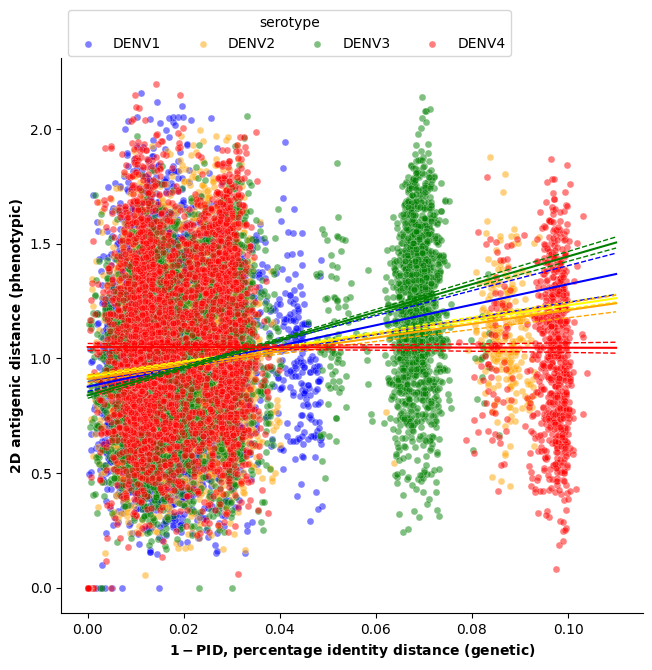

In [14]:
data_reg_homo_df = data_reg_df[data_reg_df.serotype1==data_reg_df.serotype2]
x_homo           = 1-data_reg_homo_df.pid.values
y_homo           = np.sqrt(data_reg_homo_df.antigenic_distance.values)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.2))


indexes_homo, _ = cross_val_indexes(len(data_reg_homo_df), n_train_frac=100, K=1000)
y_hat_all       = np.full((len(data_reg_homo_df), 1000), np.nan)

x_pred = np.linspace(0, 1-0.89, len(data_reg_homo_df))
for ki in range(indexes_homo.shape[0]):
    θ, y_hat_all[:, ki] = linear_regression(x_homo[indexes_homo[ki, :]], y_homo[indexes_homo[ki, :]], x_pred)

y_pred_df = pd.DataFrame(columns=["mean", "up_95", "low_95"], data=np.c_[np.mean(y_hat_all, -1, keepdims=True),
                                                                    np.quantile(y_hat_all, (1-0.05, 0.05), axis=1).T])

ax.plot(x_pred, y_pred_df["low_95"], color="yellow", lw=1, ls="--")
ax.plot(x_pred, y_pred_df["up_95"], color="yellow", lw=1, ls="--")
ax.plot(x_pred, y_pred_df["mean"], color="yellow", lw=1.5)

data_reg_homo_df["ant_dist_sqrt"] = np.sqrt(data_reg_homo_df["antigenic_distance"])
serotypes = ["DENV1", "DENV2", "DENV3", "DENV4"]
color     = ["blue", "orange", "green", "red"]
θ_homo_all     = np.full((len(serotypes), 2, 1000), np.nan)

for i_sero, sero in enumerate(serotypes):
    data_reg_homo_sero_df = data_reg_df.query(f"serotype1==serotype2 and serotype1=='{sero}'")
    x_homo                = 1-data_reg_homo_sero_df.pid.values
    y_homo                = np.sqrt(data_reg_homo_sero_df.antigenic_distance.values)

    indexes_homo, _ = cross_val_indexes(len(data_reg_homo_sero_df), n_train_frac=100, K=1000)
    y_hat_all       = np.full((len(data_reg_homo_sero_df), 1000), np.nan)

    x_pred = np.linspace(0, 1-0.89, len(data_reg_homo_sero_df))
    for ki in range(indexes_homo.shape[0]):
        θ, y_hat_all[:, ki] = linear_regression(x_homo[indexes_homo[ki, :]],
                                                y_homo[indexes_homo[ki, :]], x_pred)
        θ_homo_all[i_sero, :, ki] = θ

    y_pred_df = pd.DataFrame(columns=["mean", "up_95", "low_95"], data=np.c_[np.mean(y_hat_all, -1, keepdims=True),
                                                                        np.quantile(y_hat_all, (1-0.05, 0.05), axis=1).T])

    ax.scatter(x_homo, y_homo, fc=color[i_sero], ec="w", lw=0.3,
                                                s=25, alpha=0.5, label=sero)

    ax.plot(x_pred, y_pred_df["low_95"], color=color[i_sero], lw=1, ls="--")
    ax.plot(x_pred, y_pred_df["up_95"], color=color[i_sero], lw=1, ls="--")
    ax.plot(x_pred, y_pred_df["mean"], color=color[i_sero], lw=1.5)

ax.legend(bbox_to_anchor=(0, 1.1), loc="upper left", ncol=4, title="serotype")

ax.set_xlabel(r"$\mathbf{1-}$PID, percentage identity distance (genetic)", weight="bold")
ax.set_ylabel("2D antigenic distance (phenotypic)", weight="bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_75483/486588535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg_hetero_df["label"] = data_reg_hetero_df.apply(lambda x: x.serotype2+"-"+x.serotype1, axis=1)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_75483/486588535.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg_hetero_df["ant_dist_sqrt"] = np.sqrt(data_reg_hetero_df["antigenic_distance"])


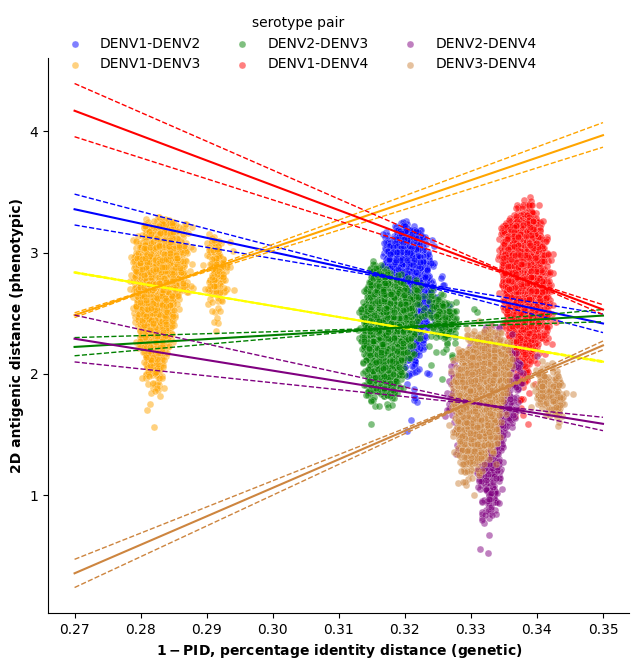

In [15]:

data_reg_hetero_df          = data_reg_df[data_reg_df.serotype1!=data_reg_df.serotype2]
data_reg_hetero_df["label"] = data_reg_hetero_df.apply(lambda x: x.serotype2+"-"+x.serotype1, axis=1)

x_hetero           = 1 - data_reg_hetero_df.pid.values
y_hetero           = data_reg_hetero_df.antigenic_distance.values

indexes_hetero, _ = cross_val_indexes(len(data_reg_hetero_df), n_train_frac=100, K=1000)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.2))


indexes_hetero, _ = cross_val_indexes(len(data_reg_hetero_df), n_train_frac=100, K=1000)
y_hat_all         = np.full((len(data_reg_hetero_df), 1000), np.nan)

x_pred = np.linspace(1-0.73, 1-0.65, len(data_reg_hetero_df))
for ki in range(indexes_hetero.shape[0]):
    θ, y_hat_all[:, ki]  =  linear_regression(x_hetero[indexes_hetero[ki, :]], np.sqrt(y_hetero[indexes_hetero[ki, :]]), x_pred)

y_pred_df = pd.DataFrame(columns=["mean", "up_95", "low_95"], data=np.c_[np.mean(y_hat_all, -1, keepdims=True),
                                                                    np.quantile(y_hat_all, (1-0.05, 0.05), axis=1).T])

#ax.fill_between(x_pred, y_pred_df.low_95, y_pred_df.up_95, color="gray", alpha=0.3)
ax.plot(x_pred, y_pred_df["low_95"], color="yellow", lw=1, ls="--")
ax.plot(x_pred, y_pred_df["up_95"], color="yellow", lw=1, ls="--")
ax.plot(x_pred, y_pred_df["mean"], color="yellow", lw=1.5)

data_reg_hetero_df["ant_dist_sqrt"] = np.sqrt(data_reg_hetero_df["antigenic_distance"])

color     = ["blue", "orange", "green", "red", "purple", "peru"]
sero_pair = ['DENV1-DENV2', 'DENV1-DENV3', 'DENV2-DENV3', 'DENV1-DENV4', 'DENV2-DENV4', 'DENV3-DENV4']

θ_hetero_all = np.full((len(sero_pair), 2, 1000), np.nan)

for i_sero, sero in enumerate(sero_pair):
    sero1, sero2 = sero.split("-")
    data_reg_hetero_sero_df = data_reg_df.query(f"serotype1!=serotype2 and serotype2=='{sero1}' and serotype1=='{sero2}'")

    x_hetero                = 1-data_reg_hetero_sero_df.pid.values
    y_hetero                = np.sqrt(data_reg_hetero_sero_df.antigenic_distance.values)

    indexes_hetero, _ = cross_val_indexes(len(data_reg_hetero_sero_df), n_train_frac=100, K=1000)
    y_hat_all         = np.full((len(data_reg_hetero_sero_df), 1000), np.nan)

    x_pred = np.linspace(1-0.73, 1-0.65,  len(data_reg_hetero_sero_df))
    for ki in range(indexes_hetero.shape[0]):
        θ, y_hat_all[:, ki]  = linear_regression(x_hetero[indexes_hetero[ki, :]], y_hetero[indexes_hetero[ki, :]], x_pred)
        θ_hetero_all[i_sero, :, ki] = θ


    y_pred_df = pd.DataFrame(columns=["mean", "up_95", "low_95"], data=np.c_[np.mean(y_hat_all, -1, keepdims=True),
                                                                        np.quantile(y_hat_all, (1-0.05, 0.05), axis=1).T])

    ax.scatter(x_hetero, y_hetero, fc=color[i_sero], ec="w", lw=0.3,
                                                s=25, alpha=0.5, label=sero)

    ax.plot(x_pred, y_pred_df["low_95"], color=color[i_sero], lw=1, ls="--")
    ax.plot(x_pred, y_pred_df["up_95"], color=color[i_sero], lw=1, ls="--")
    ax.plot(x_pred, y_pred_df["mean"], color=color[i_sero], lw=1.5)

ax.legend(bbox_to_anchor=(0, 1.1), loc="upper left", ncol=3, title="serotype pair", frameon=False)

ax.set_xlabel(r"$\mathbf{1-}$PID, percentage identity distance (genetic)", weight="bold")
ax.set_ylabel("2D antigenic distance (phenotypic)", weight="bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


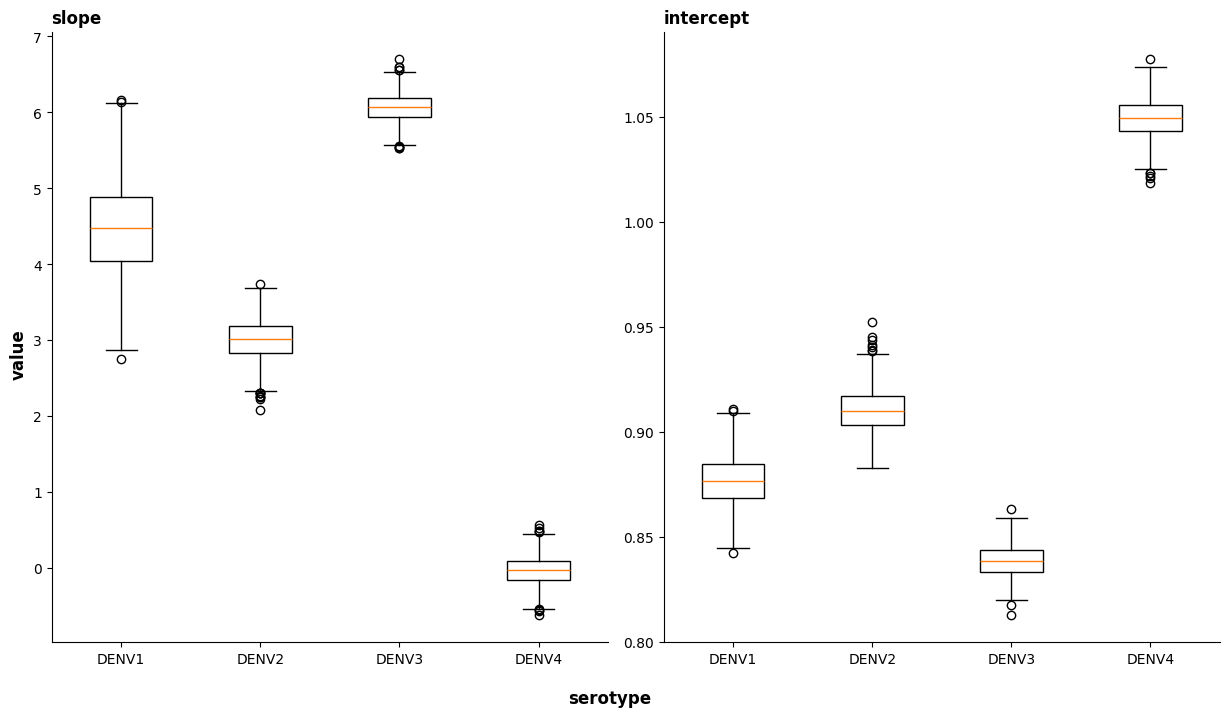

In [31]:
θ_homo_all.shape

fig, ax = plt.subplots(1, 2, figsize=(12.5, 7.2))

bplot1 = ax[0].boxplot(θ_homo_all[:, 1, :].T,
                        patch_artist = True,  # fill with color
                        labels       = serotypes)  # will be used to label x-ticks

bplot2 = ax[1].boxplot(θ_homo_all[:, 0, :].T,
                        patch_artist = True,  # fill with color
                        labels       = serotypes)  # will be used to label x-ticks

for axi in ax.flatten():
    axi.spines["right"].set_visible(False)
    axi.spines["top"].set_visible(False)

for patch in bplot1['boxes']+bplot2['boxes']:
    patch.set_facecolor("w")
    patch.set_edgecolor("k")

ax[0].set_title("slope",     loc="left", weight="bold")
ax[1].set_title("intercept", loc="left", weight="bold")

fig.supxlabel("serotype", weight="bold")
fig.supylabel("value", weight="bold")

plt.tight_layout()

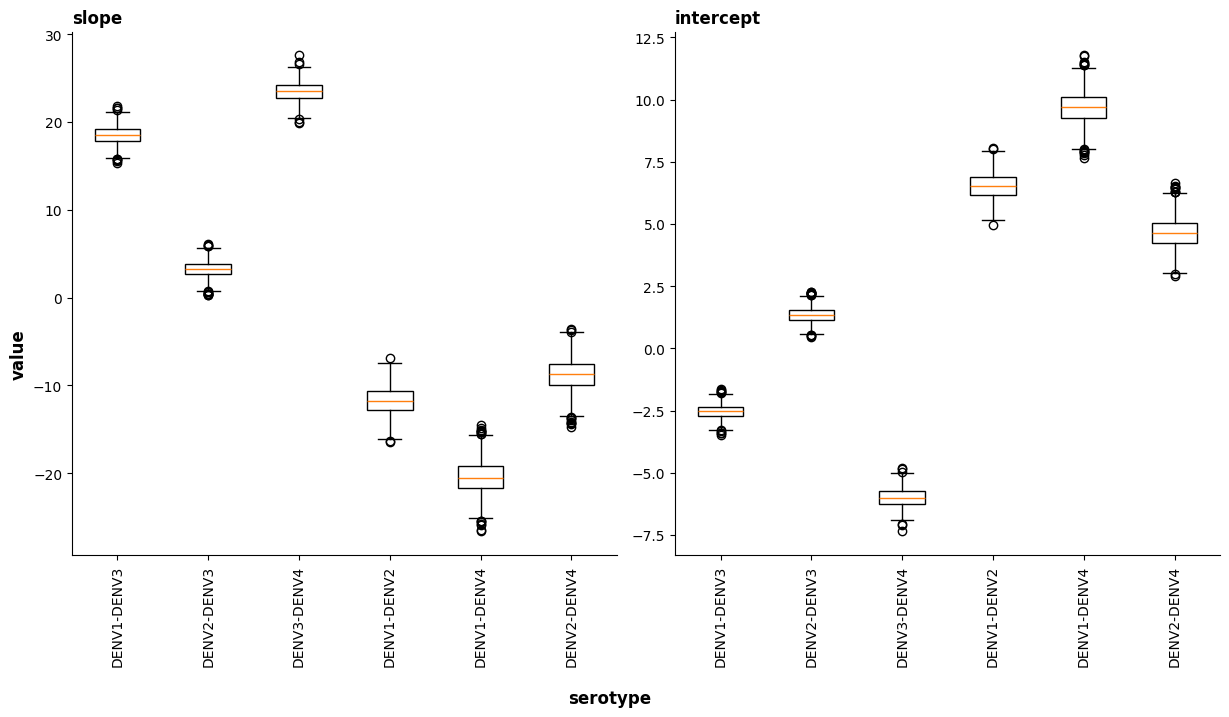

In [43]:
sero_pair = ['DENV1-DENV2', 'DENV1-DENV3', 'DENV2-DENV3', 'DENV1-DENV4', 'DENV2-DENV4', 'DENV3-DENV4']
indexes   = [1, 2, 5, 0, 3, 4]

fig, ax = plt.subplots(1, 2, figsize=(12.5, 7.2))

bplot1 = ax[0].boxplot(θ_hetero_all[indexes, 1, :].T,
                        patch_artist = True,  # fill with color
                        labels       = [sero_pair[i] for i in indexes])  # will be used to label x-ticks

bplot2 = ax[1].boxplot(θ_hetero_all[indexes, 0, :].T,
                        patch_artist = True,  # fill with color
                        labels       = [sero_pair[i] for i in indexes])  # will be used to label x-ticks

for axi in ax.flatten():
    axi.spines["right"].set_visible(False)
    axi.spines["top"].set_visible(False)

for patch in bplot1['boxes']+bplot2['boxes']:
    patch.set_facecolor("w")
    patch.set_edgecolor("k")

ax[0].set_title("slope",     loc="left", weight="bold")
ax[1].set_title("intercept", loc="left", weight="bold")

ax[0].set_xticklabels(labels=[sero_pair[i] for i in indexes], rotation=90)
ax[1].set_xticklabels(labels=[sero_pair[i] for i in indexes], rotation=90)

fig.supxlabel("serotype", weight="bold")
fig.supylabel("value", weight="bold")

plt.tight_layout()

